This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [1]:
import os
import errno

import pandas as pd
import numpy as np

import deepcell

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Load data - note, /data is mounted to /images
# normalize raw
from deepcell_toolbox.processing import phase_preprocess

filepath = '/images/data/cells/MouseBrain/3D_annotations/'
set_nums = 2

X = []
y = []

for set_num in range(set_nums):
    path_to_npz = os.path.join(filepath, 'mov_{}'.format(set_num), 'mov_{}_edited.npz'.format(set_num))

    with np.load(path_to_npz) as load_data:
        X_set = load_data['X']
        y_set = load_data['y']
        
    
    X.append(np.expand_dims(X_set[..., 0], axis=-1))
    y.append(y_set)
    
X = np.asarray(X)
y = np.asarray(y)


for frame in range(X.shape[1]):

    X[:, frame, ...] = phase_preprocess(X[:, frame, ...])

print('Shape of X is {} and shape of y is {}'.format(X.shape, y.shape))





Shape of X is (2, 47, 1024, 1024, 1) and shape of y is (2, 47, 1024, 1024, 1)


In [3]:
from deepcell_toolbox.utils import tile_image_3D, untile_image_3D

im_shape = (21, 128, 128)
stride_ratio = 0.75

X_ims, tiles_info_X = tile_image_3D(X, model_input_shape=im_shape, stride_ratio=stride_ratio)
y_ims, tiles_info_y = tile_image_3D(y, model_input_shape=im_shape, stride_ratio=stride_ratio)

print('Shape of X_ims is {} and shape of y_ims is {}'.format(X_ims.shape, y_ims.shape))


#from deepcell.utils.data_utils import reshape_movie

#size = 256

#X_ims, y_cut = reshape_movie(X, y, reshape_size=size)
#print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

Shape of X_ims is (726, 21, 128, 128, 1) and shape of y_ims is (726, 21, 128, 128, 1)


In [4]:
from sklearn.model_selection import train_test_split

test_size = 0.1
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X_ims, y_ims, test_size=test_size, random_state=seed)
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (653, 21, 128, 128, 1)
y.shape: (653, 21, 128, 128, 1)


## Set up filepath constants


In [5]:
filename = 'mov_0_edited.npz'

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join(filepath, 'mov_0'))


# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [6]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/images'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [7]:
frames_per_batch = 20
temporal_mode = 'conv'

In [17]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=3,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through [keras_applications](https://github.com/keras-team/keras-applications) and can be instantiated with weights that are pretrained on ImageNet.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.


In [8]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'mousebrain3D_0'
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

fill_mode = 'wrap'
cval = 0

n_epoch = 5  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 1  # throw out images with fewer than this many objects

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [11]:
from deepcell import image_generators
from deepcell.utils import train_utils

# if by_frame = True, transform inner and outer distance frame by frame
# if by_frame = False, transform inner and outer distance as 3D
by_frame_inner = False
by_frame_outer = True

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer},
                     'inner-distance': {'by_frame' : by_frame_inner}}



# use augmentation for training but not validation
datagen = image_generators.SemanticMovieGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=True,
    vertical_flip=True, 
    z_transform=True)

datagen_val = image_generators.SemanticMovieGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=0,
    vertical_flip=0,
    z_transform=True)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)


TypeError: __init__() got an unexpected keyword argument 'z_transform'

Visualize the data generator output.

{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 180, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0, 'zoom_range': [0.75, 1.25], 'channel_shift_range': 0.0, 'fill_mode': 'wrap', 'cval': 0, 'horizontal_flip': True, 'vertical_flip': True, 'rescale': None, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'principal_components': None, 'brightness_range': None, 'time_axis': 0}
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1)
(20, 128, 128, 1

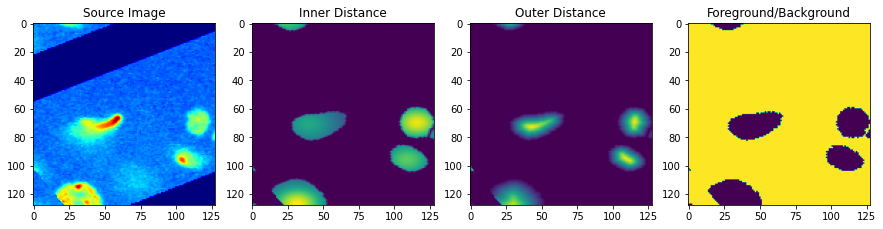

In [12]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

slice=12

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [21]:
#vid_transform = np.expand_dims(y_test, axis=1)

# DISCLAIMER - each frame of the video is independently scaled, rather than the video as a whole

HTML(get_js_video(outputs[0], batch=0, channel=0, interval=500, vmin=0, vmax=outputs[1].max()))

In [22]:
HTML(get_js_video(inputs, batch=0, channel=0, interval=500, vmin=0, vmax=inputs.max()))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [24]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [25]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [27]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 61/582 [==>...........................] - ETA: 1:31 - loss: 0.0166 - semantic_0_loss: 0.0069 - semantic_1_loss: 0.0065 - semantic_2_loss: 0.0032
Epoch 00001: val_loss improved from inf to 0.01664, saving model to /images/models/mousebrain3D_0.h5
582/582 [==============================] - 330s 568ms/step - loss: 0.0463 - semantic_0_loss: 0.0164 - semantic_1_loss: 0.0255 - semantic_2_loss: 0.0043 - val_loss: 0.0166 - val_semantic_0_loss: 0.0069 - val_semantic_1_loss: 0.0065 - val_semantic_2_loss: 0.0032
Epoch 2/5
 61/582 [==>...........................] - ETA: 55s - loss: 0.0118 - semantic_0_loss: 0.0059 - semantic_1_loss: 0.0037 - semantic_2_loss: 0.0021
Epoch 00002: val_loss improved from 0.01664 to 0.01176, saving model to /images/models/mousebrain3D_0.h5
582/582 [==============================] - 258s 443ms/step - loss: 0.0133 - semantic_0_loss: 0.0064 - semant

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [390]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy.ndimage as nd

from skimage.feature import peak_local_max, corner_peaks
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import erode_edges

def deep_watershed_3D(outputs,
                   min_distance=10,
                   detection_threshold=0.1,
                   distance_threshold=0.01,
                   exclude_border=False,
                   small_objects_threshold=0):
    """Postprocessing function for deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the outer distance prediction.

    Args:
        outputs (list): DeepWatershed model output. A list of
            [inner_distance, outer_distance, fgbg].

            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Prediction for the foregound/background transform.

        min_distance (int): Minimum allowable distance between two cell centroids2.
        detection_threshold (float): Threshold for the inner distance.
        distance_threshold (float): Threshold for the outer distance.
        exclude_border (bool): Whether to include centroid detections
            at the border.
        small_objects_threshold (int): Removes objects smaller than this size.

    Returns:
        numpy.array: Uniquely labeled mask.
    """
    inner_distance_batch = outputs[0][:, ..., 0]
    outer_distance_batch = outputs[1][:, ..., 0]

    label_images = []
    for batch in range(inner_distance_batch.shape[0]):
        inner_distance = inner_distance_batch[batch]
        outer_distance = outer_distance_batch[batch]

        coords = peak_local_max(inner_distance,
                                min_distance=min_distance,
                                threshold_abs=detection_threshold,
                                exclude_border=exclude_border)
        
        # Find peaks and merge equal regions        
        markers = np.zeros(inner_distance.shape)
        markers[coords[:, 0], coords[:, 1], coords[:,2]] = 1
        markers = label(markers)        
        
        label_image = watershed(-outer_distance,
                                markers,
                                mask=outer_distance > distance_threshold)
        label_image = erode_edges(label_image, 1)

        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        label_images.append(label_image)
    
    label_images = np.stack(label_images, axis=0)

    return label_images

                                                                  

In [28]:
from deepcell.model_zoo.panopticnet import PanopticNet       

pred_frames_per_batch = frames_per_batch

prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=pred_frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

In [29]:
prediction_model.load_weights(model_path, by_name=True)

In [383]:
# make predictions on testing data
from timeit import default_timer

f_mov = 2
l_mov = f_mov+1
batch_size = 1

start = default_timer()
test_images = prediction_model.predict(X_test[f_mov:l_mov, 0:pred_frames_per_batch, ...], batch_size=batch_size)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (1, 20, 128, 128, 1) in 0.1381913989316672 seconds.


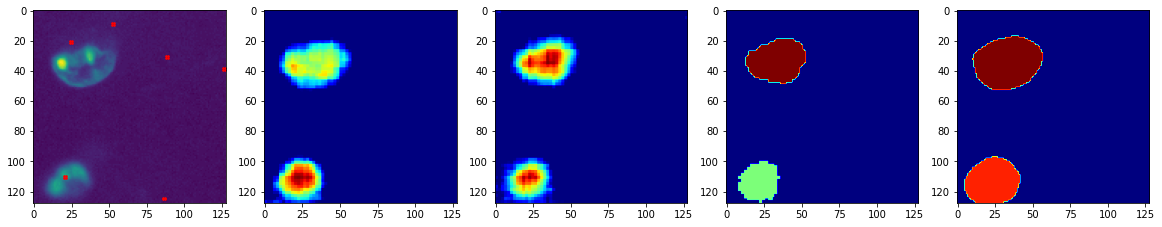

In [392]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects

#from deepcell_toolbox.deep_watershed import deep_watershed_3D

min_distance = 16          # minimum allowable distance between two centroid coords
detection_threshold = 0.1  # absolute threshold for minimum peak intensity (TODO - relative threshold)
distance_threshold = 0.1  # outer_distance threshold for cell border
small_objects_threshold = 0

masks = deep_watershed_3D(
    test_images,
    min_distance=min_distance,
    detection_threshold=detection_threshold,
    distance_threshold=distance_threshold,
    exclude_border=False,
    small_objects_threshold=small_objects_threshold)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

index = 0
slice = 0
coords = peak_local_max(
    np.squeeze(inner_distance[index]),
    min_distance=min_distance,
    threshold_abs=detection_threshold,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index+f_mov, slice, ..., 0])
axes[0].scatter(coords[..., 2], coords[..., 1],
                color='r', marker='.', s=10)

# raw image xz plane
#axes[0].imshow(X_test[index+f_mov, :, 150, :, 0])
#axes[0].scatter(coords[..., 2], coords[..., 0], color='r', marker='.', s=10)
    
    
axes[1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[3].imshow(masks[index, slice, ...], cmap='jet')
axes[4].imshow(np.squeeze(y_test[index+f_mov, slice, ...]), cmap='jet')

plt.show()

In [385]:
np.unique(masks)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [395]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

index = index


# Play movie of the predicted masks
vid_msk = np.expand_dims(masks, axis=1)
vid_msk = np.expand_dims(vid_msk, axis=-1)

HTML(get_js_video(vid_msk[index], batch=0, channel=0, interval=500))

In [394]:
HTML(get_js_video(y_test, batch=index+f_mov, channel=0, interval=500))

In [400]:
np.unique(y_test[index+f_mov, 0:pred_frames_per_batch, ...])

array([  0, 110, 126, 156, 195, 248, 251, 252, 273, 299], dtype=uint16)

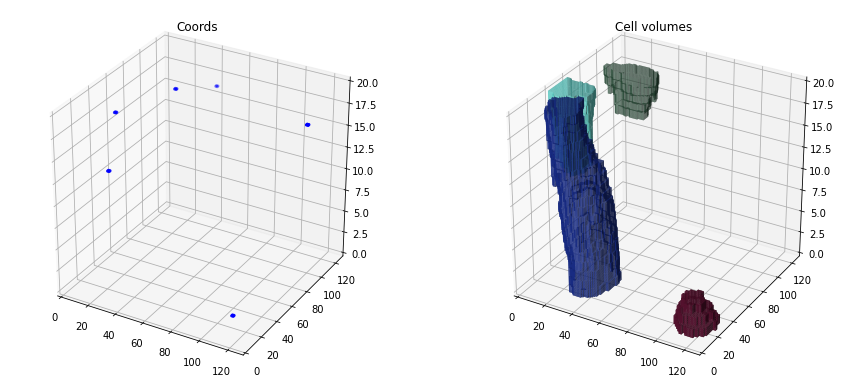

In [406]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_max = 128
y_max = 128
z_max = 20


fig = plt.figure(figsize=(15, 15))

# Cell centroid coordinates 
ax = fig.add_subplot(221, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(0,z_max)
test_plot = coords
ax.scatter(test_plot[:, 1], test_plot[:, 2], test_plot[:, 0], c='b', marker='o', s=5)
ax.set_title('Coords')


# Cell volumes
ax = fig.add_subplot(222, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(0,z_max)

plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

colors = np.empty(plot_masks.shape, dtype='<U9')

color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'

    color_dict[label] = color
    
    facecolors = np.where(plot_masks==label, color, facecolors)

ax.voxels(plot_masks, facecolors=facecolors)
ax.set_title('Cell volumes')


plt.show()

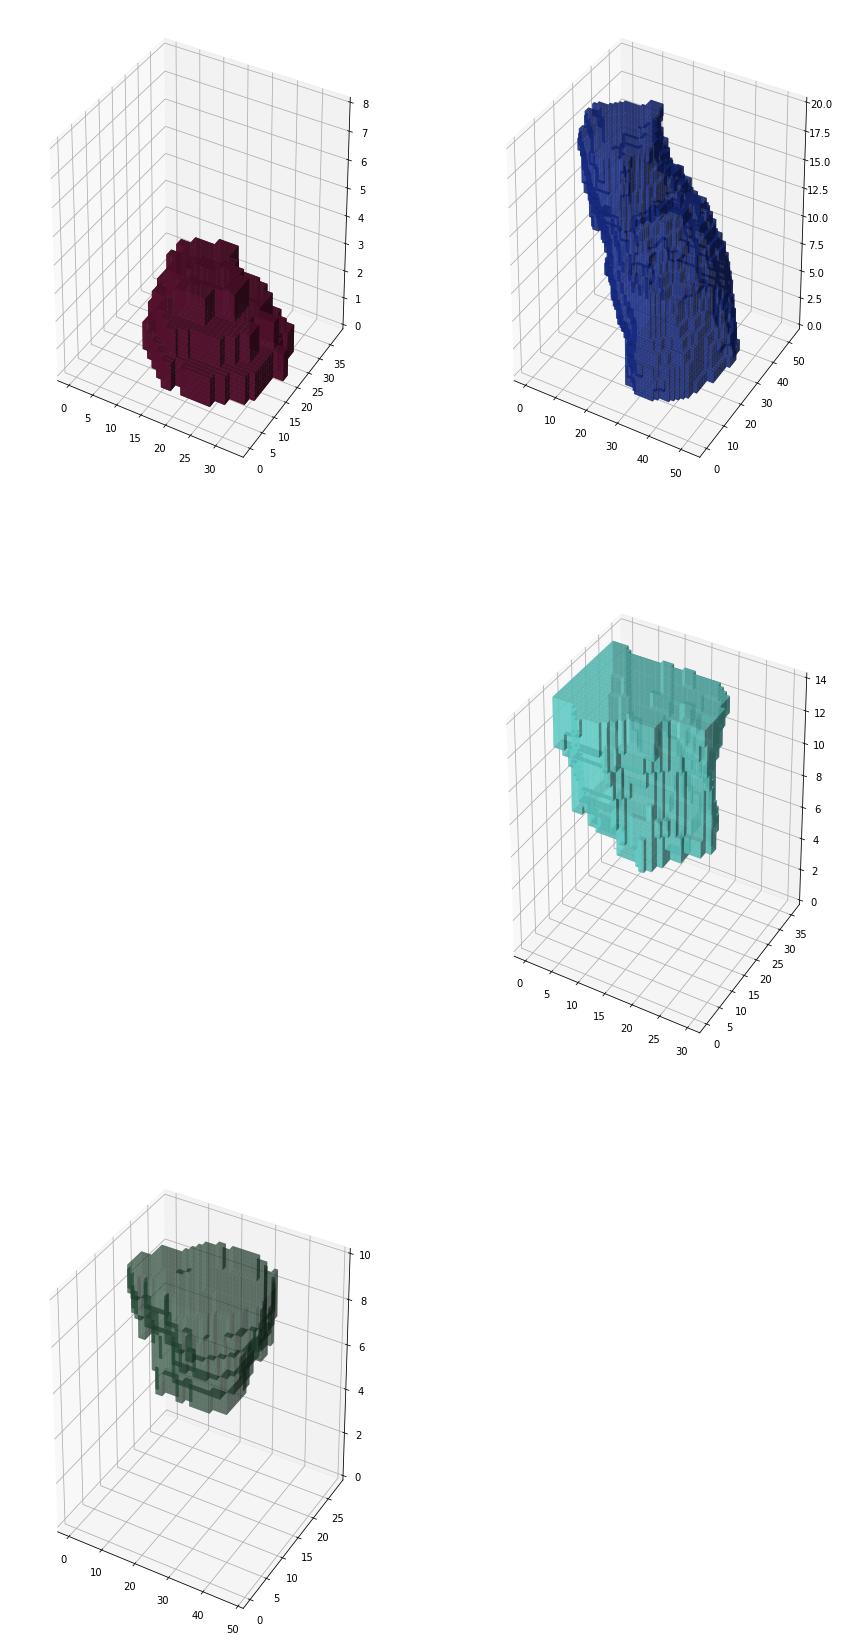

In [407]:
x_max = 128
y_max = 128
z_max = 20
padding = 5

fig = plt.figure(figsize=(15, 30))

plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

cell_ids = np.unique(plot_masks)[1:]
num_cells = max(cell_ids)

num_rows = int(np.ceil(num_cells / 2))
num_cols = 2


for cell in cell_ids:
    
    cell_mask = np.where(plot_masks == cell, plot_masks, 0)
    props = regionprops(cell_mask)
    bbox = props[0].bbox
    
    y_min = max(0, bbox[0] - padding)
    y_max = bbox[3] + padding
    x_min = max(0, bbox[1] - padding)
    x_max = bbox[4] + padding
    z_min = max(0, bbox[2] - padding)
    z_max = bbox[5] + padding
    
    # Cell volumes
    
    plot_num = int(str(num_rows) + str(num_cols) + str(cell))
    
    ax = fig.add_subplot(plot_num, projection='3d')

    ax.voxels(cell_mask[y_min:y_max, x_min:x_max, z_min:z_max], facecolors=color_dict[cell])
    

plt.show()
    



In [404]:
from deepcell_toolbox.metrics import Metrics
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border
'''
outputs = prediction_model.predict(X_test)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        min_distance=10,
        detection_threshold=0.1,
        distance_threshold=0.01,
        exclude_border=False,
        small_objects_threshold=0)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = y_test.copy()
'''

y_pred = np.rollaxis(masks, 0, 4)
y_true = y_test[index+f_mov, 0:pred_frames_per_batch, ...].copy()

print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

print('DeepWatershed - Remove no pixels')
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

print('DeepWatershed - Remove objects < 100 pixels')
m = Metrics('DeepWatershed - Remove 100 pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

Shape of y_pred is (20, 128, 128, 1) and shape of y_true is (20, 128, 128, 1)
DeepWatershed - Remove no pixels

____________Object-based statistics____________

Number of true cells:		 75
Number of predicted cells:	 49

Correct detections:  14	Recall: 18.666666666666667850904559600166976451873779296875%
Incorrect detections: 35	Precision: 28.571428571428572951163005200214684009552001953125%

Gained detections: 35	Perc Error: 36.45833333333333570180911920033395290374755859375%
Missed detections: 61	Perc Error: 63.54166666666666429819088079966604709625244140625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5224713931043833969880552103859372437000274658203125 



DeepWatershed - Remove objects < 100 pixels

____________Object-based statistics____________
